# 시청률 요일별 분석

## 1. 시청률 엑셀 파일 분석

NaN값은 없다.

> ### 컬럼
* 분단위 시간대(object)
* 365일간의 날짜별 시청률(float)
* 해당 시간의 1년간 평균 (우측으로 마지막 컬럼)

파일에서 가장 마지막 행은 해당 날짜의 평균 시청률을 의미한다.

* 마지막 행: 해당 날짜의 평균 시청률
* 마지막 열: 1년간 해당 시간대의 평균 시청률



In [1]:
import pandas as pd

rating = pd.read_csv(r'./raw/시청률.csv')

print(rating.shape)

rating.info()

(1441, 367)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Columns: 367 entries, 시간대 to 2019-01-01 to 2019-12-31
dtypes: float64(366), object(1)
memory usage: 4.0+ MB


In [2]:
rating.head()

,시간대,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,...,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,2019-01-01 to 2019-12-31
0,02:00,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.003
1,02:01,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.012,0.003
2,02:02,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.004
3,02:03,0.0,0.0,0.014,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.017,0.0,0.0,0.0,0.0,0.0,0.000,0.004
4,02:04,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.017,0.0,0.0,0.0,0.0,0.0,0.000,0.004


우선은 파일에서 주어진 일일 시청률 평균을 분석해본다.

### 1-1. 일별 평균 시청률 DataFrame 생성

평균은 소수점 네번째 자리에서 버림으로 표시한다.


In [3]:
meanYear = rating.drop(['시간대','2019-01-01 to 2019-12-31'],axis=1)
meanYear = meanYear.iloc[1440,:]
meanYear

2019-01-01    0.004
2019-01-02    0.006
2019-01-03    0.002
2019-01-04    0.003
2019-01-05    0.002
              ...  
2019-12-27    0.004
2019-12-28    0.006
2019-12-29    0.004
2019-12-30    0.005
2019-12-31    0.005
Name: 1440, Length: 365, dtype: float64

인덱스가 날짜로 지정되어 있는데, 정수로 바꿔준다.

In [4]:
meanYear_df = meanYear.reset_index()
meanYear_df.columns = ['date','rating']
meanYear_df

,date,rating
0,2019-01-01,0.004
1,2019-01-02,0.006
2,2019-01-03,0.002
3,2019-01-04,0.003
4,2019-01-05,0.002
...,...,...
360,2019-12-27,0.004
361,2019-12-28,0.006
362,2019-12-29,0.004
363,2019-12-30,0.005


### 1-2. 분석에 필요한 정보를 컬럼형식으로 추가

1. date: 날짜를 datetime 포맷으로 바꿔준다.
2. day: 그 날짜가 무슨 요일인지 넣는다. (object)
3. month: 몇월인지 (object)
4. week: 2019년에서 몇번째 주인지 (int)

In [5]:
meanYear_df['date'] = pd.to_datetime(meanYear_df['date'], format='%Y/%m/%d')
meanYear_df['day'] = meanYear_df['date'].dt.day_name()
meanYear_df['month'] = meanYear_df['date'].dt.strftime('%m')
meanYear_df['week'] = meanYear_df['date'].dt.strftime('%U').astype(int)

meanYear_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    365 non-null    datetime64[ns]
 1   rating  365 non-null    float64       
 2   day     365 non-null    object        
 3   month   365 non-null    object        
 4   week    365 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(2)
memory usage: 13.0+ KB


### 1-3. 검색 조건, 그래프 color 리스트 생성

필요한 조건을 함수로 정의하고, 달,요일,주간별로 필요한 list를 만든다.

요일 이름 리스트, 그리고 각 기준마다 색깔을 저장한 리스트를 만들었다.

In [6]:
month_list = ['01','02','03','04','05','06','07','08','09','10','11','12']
mon_color = ['tomato','orange','goldenrod','lawngreen','turquoise','blueviolet','violet',
            'aqua','red','blue','chartreuse','deeppink','black']

day_list = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
day_kor = ['월','화','수','목','금','토','일']
day_color = ['orange','red','blue','lime','magenta','blueviolet','black']

week_color = ['black','tomato','limegreen','orange','violet','turquoise','dimgray']

In [7]:
# i월의 j요일을 출력한다.
def date_case(i,j):
    case_mon = meanYear_df['month'] == month_list[i]
    case_day = meanYear_df['day'] == day_list[j]
    
    return case_mon & case_day

#i월의 j주차 정보를 출력한다.
def date_case2(i,j):
    case_mon = meanYear_df['month'] == month_list[i]
    case_week = meanYear_df['week'] == j
    
    return case_mon & case_week

## 2. 특정 요일의 월간 시청률 그래프

### 2-1. 그래프 스타일 지정

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#plt.style.use('ggplot')

# 한글 오류 해결하기
from matplotlib import font_manager, rc
font_path = './font/나눔고딕.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font',family=font_name)

> ## 특정 요일의 월간 시청률 그래프
> ### 그래프 정보
* x축: 해당 월의 주차 (ex: 1월 1일은 1월의 1주차에 해당)
* y축: 시청률

각 포인트마다의 날짜는 따로 확인해야한다.


In [9]:
# day = 요일 입력 ex: 0==월요일
# mon = 몇월까지 출력할지?
# var = 여러개 출력할건지 (T/F)

def day_graph(mon,day,var):
    figure(num=None, figsize=(6,4))
    
    plt.xlabel('주차')
    plt.ylabel('RAT')
    
    if var is True: # mon월까지의 정보를 출력
        for i in range(mon):
            y = meanYear_df[date_case(i,day)]['rating'].to_list()
            
            plt.plot(y,marker='o',markersize=3,color=mon_color[i],linestyle='--')
            
            plt.legend(month_list,loc='center left',ncol=2, bbox_to_anchor=(1,0.5))
            plt.title('2019년 '+day_kor[day]+'요일 평균 시청률')
            
    else: # mon월의 정보만을 출력
        y = meanYear_df[date_case(mon,day)]['rating'].to_list()
        
        plt.plot(y,marker='o',markersize=3,label=repr(mon+1),color=day_color[day],linestyle='--')
        
        plt.legend(loc='best')
        plt.title(repr(mon+1)+'월간 '+day_kor[day]+'요일 평균 시청률')
    
    plt.xticks(np.arange(0,5),['1','2','3','4','5'])
    plt.yticks(np.arange(0,0.013,0.002))
    
    #plt.grid(True)
    
    plt.show()

> ### 전체 요일 평균 (1년치)

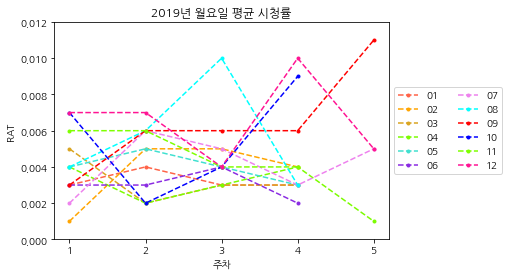

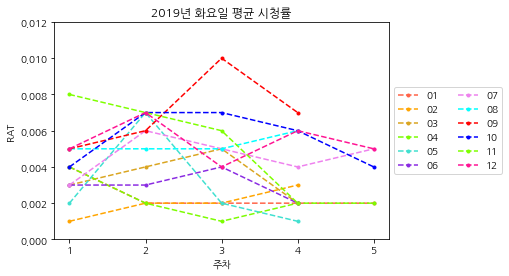

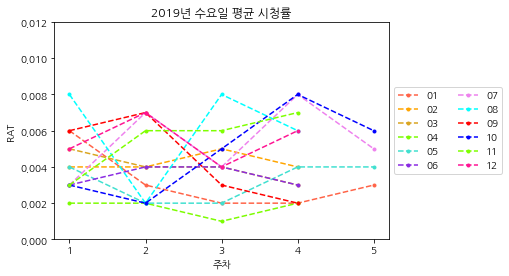

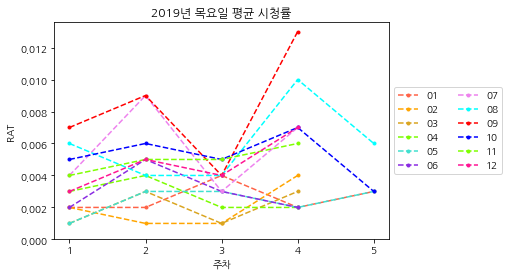

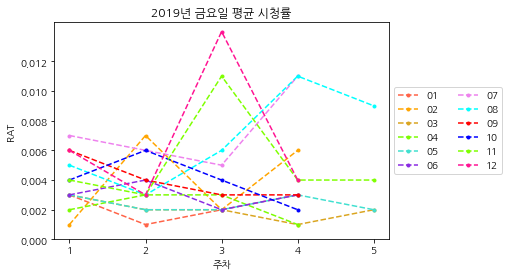

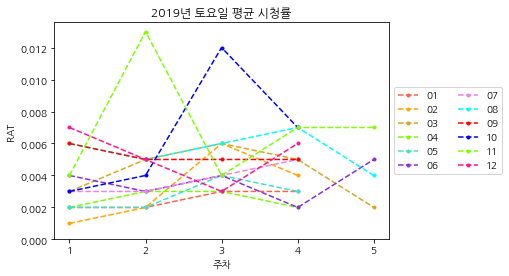

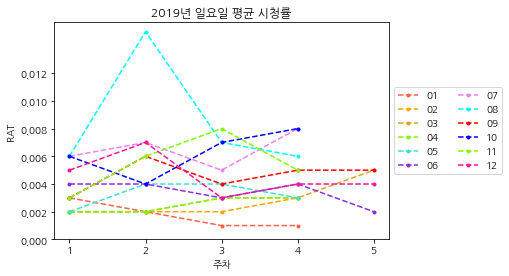

In [10]:
for day in range(7):
    day_graph(12,day,True)

> ### 1월~12월 요일별 평균(요일마다)
길기 때문에 필요할 때 실행.

In [11]:
#for day in range(7):
#    for mon in range(12):
#        day_graph(mon,day,False)

## 3. 주간 평균 시청률 그래프

참고: x축과 y축 인덱스 개수가 같아야지 그래프를 그릴 수 있음!

### 3-1. 요일 정보 바꾸기

월요일:0 / 일요일:6 으로 숫자를 지정하면 그래프의 가독성이 떨어진다.

요일을 숫자로 표현하는 컬럼을 추가하자. 월요일이 0이니까 일요일은 6이다.

6은 -1로 바꾸자!

In [12]:
meanYear_df['day_int'] = meanYear_df['date'].dt.weekday.replace(6,-1)
meanYear_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     365 non-null    datetime64[ns]
 1   rating   365 non-null    float64       
 2   day      365 non-null    object        
 3   month    365 non-null    object        
 4   week     365 non-null    int32         
 5   day_int  365 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(2)
memory usage: 15.8+ KB


> ##  주간 평균 시청률 그래프
> ### 그래프 정보
* x축: 요일 (월~일)
* y축: 시청률

In [13]:
# mon = 몇월까지 출력할지?
def day_graph2(mon):
    
    # 특정 월을 추출하는 조건
    case_mon = meanYear_df['month'] == month_list[mon]
    
    #특정 월 주차의 최솟값, 최댓값
    min_week = meanYear_df[case_mon]['week'].min()
    max_week = meanYear_df[case_mon]['week'].max()
    
    # 해당 월의 몇번째 주인지 센다 (df에 있는건 월이 아니라 1년 기준)
    week_num = 0
    
    figure(num=None, figsize=(8,6))
    plt.title('요일별 평균 시청률:  '+month_list[mon]+'월')
    plt.ylabel('RAT')

    for i in range(min_week,max_week+1):
        
        week_num += 1
        
        x = meanYear_df[date_case2(mon,i)]['day_int']
        y = meanYear_df[date_case2(mon,i)]['rating']
        
        plt.plot(x, y, marker='o',markersize=5,linestyle='--',
                 color=week_color[week_num], label= repr(week_num)+'주' )
        
        plt.fill_between(x, 0, y, alpha=0.2,color=week_color[week_num])
        
        plt.legend(loc='best',ncol=2)
    
    plt.xticks(np.arange(-1,6),['일','월','화','수','목','금','토'])
    plt.yticks(np.arange(0,0.013,0.002))
    
    #plt.grid(True)
    
    plt.show()

### 특정 월의 최대, 최소 시청률 정보를 출력하는 함수

In [14]:
def search_date(mon):
    df1 = meanYear_df[ meanYear_df['month'] == month_list[mon] ][['rating','date','day']]
    
    max_date = df1[ df1['rating'] == df1['rating'].max() ]
    min_date = df1[ df1['rating'] == df1['rating'].min() ]
    
    max_rate = df1['rating'].max()
    min_rate = df1['rating'].min()
    
    print('최대 시청률: ',max_rate,'\n최소 시청률: ',min_rate)
    print('-----------------------------------')
    print('시청률 최댓값 정보:\n')
    print(max_date)
    print('-----------------------------------')
    print('시청률 최솟값 정보:\n')
    print(min_date)

### 1월
---
>* max: 0.006
* min: 0.001


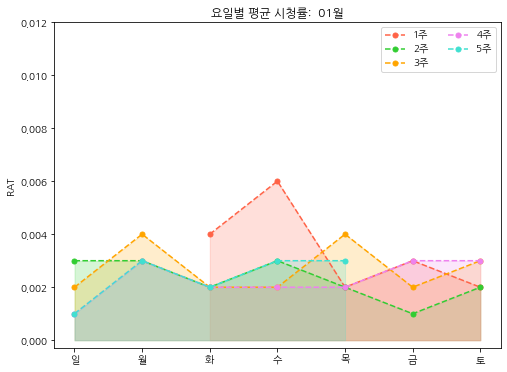

최대 시청률:  0.006 
최소 시청률:  0.001
-----------------------------------
시청률 최댓값 정보:

   rating       date        day
1   0.006 2019-01-02  Wednesday
-----------------------------------
시청률 최솟값 정보:

    rating       date     day
10   0.001 2019-01-11  Friday
19   0.001 2019-01-20  Sunday
26   0.001 2019-01-27  Sunday


In [15]:
month = 0
day_graph2(month)
search_date(month)

### 2월
---

>* max: 0.007
* min: 0.001


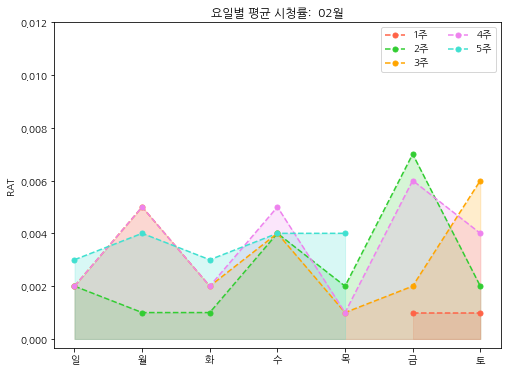

최대 시청률:  0.006999999999999999 
최소 시청률:  0.001
-----------------------------------
시청률 최댓값 정보:

    rating       date     day
38   0.007 2019-02-08  Friday
-----------------------------------
시청률 최솟값 정보:

    rating       date       day
31   0.001 2019-02-01    Friday
32   0.001 2019-02-02  Saturday
34   0.001 2019-02-04    Monday
35   0.001 2019-02-05   Tuesday
44   0.001 2019-02-14  Thursday
51   0.001 2019-02-21  Thursday


In [16]:
month = 1
day_graph2(month)
search_date(month)

### 3월

>* max: 0.006
* min: 0.001


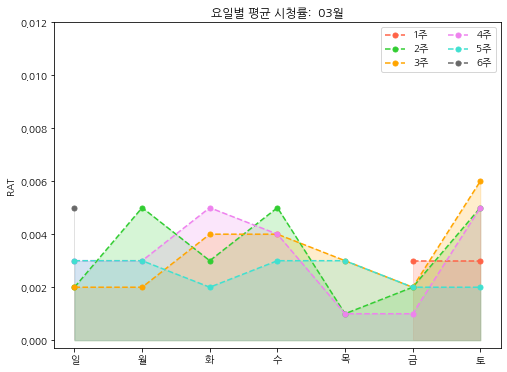

최대 시청률:  0.006 
최소 시청률:  0.001
-----------------------------------
시청률 최댓값 정보:

    rating       date       day
74   0.006 2019-03-16  Saturday
-----------------------------------
시청률 최솟값 정보:

    rating       date       day
65   0.001 2019-03-07  Thursday
79   0.001 2019-03-21  Thursday
80   0.001 2019-03-22    Friday


In [17]:
month = 2
day_graph2(month)
search_date(month)

### 4월

>* max: 0.004
* min: 0.001


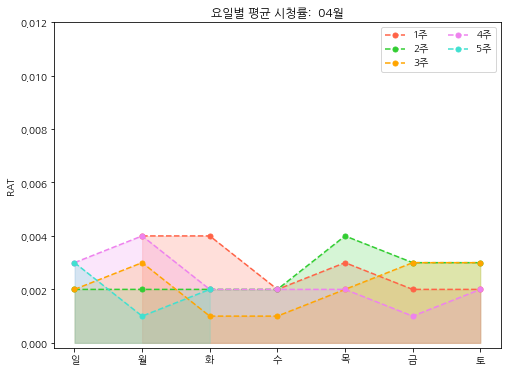

최대 시청률:  0.004 
최소 시청률:  0.001
-----------------------------------
시청률 최댓값 정보:

     rating       date       day
90    0.004 2019-04-01    Monday
91    0.004 2019-04-02   Tuesday
100   0.004 2019-04-11  Thursday
111   0.004 2019-04-22    Monday
-----------------------------------
시청률 최솟값 정보:

     rating       date        day
105   0.001 2019-04-16    Tuesday
106   0.001 2019-04-17  Wednesday
115   0.001 2019-04-26     Friday
118   0.001 2019-04-29     Monday


In [18]:
month = 3
day_graph2(month)
search_date(month)

### 5월

>* max: 0.007
* min: 0.001


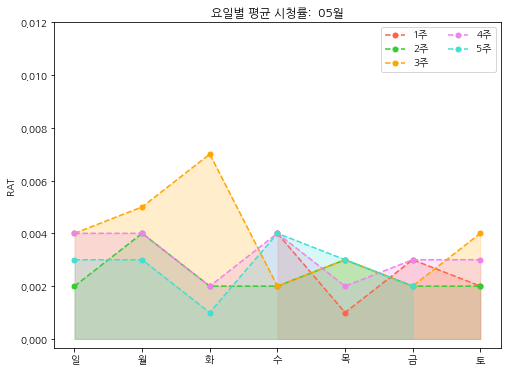

최대 시청률:  0.006999999999999999 
최소 시청률:  0.001
-----------------------------------
시청률 최댓값 정보:

     rating       date      day
133   0.007 2019-05-14  Tuesday
-----------------------------------
시청률 최솟값 정보:

     rating       date       day
121   0.001 2019-05-02  Thursday
147   0.001 2019-05-28   Tuesday


In [19]:
month = 4
day_graph2(month)
search_date(month)

### 6월

6월 1주차는 토요일 하루 뿐이다.

>* max: 0.005
* min: 0.002



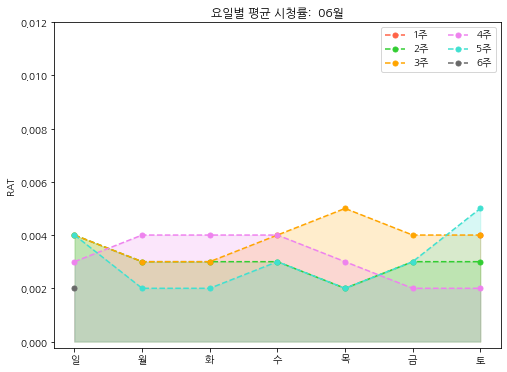

최대 시청률:  0.005 
최소 시청률:  0.002
-----------------------------------
시청률 최댓값 정보:

     rating       date       day
163   0.005 2019-06-13  Thursday
179   0.005 2019-06-29  Saturday
-----------------------------------
시청률 최솟값 정보:

     rating       date       day
156   0.002 2019-06-06  Thursday
171   0.002 2019-06-21    Friday
172   0.002 2019-06-22  Saturday
174   0.002 2019-06-24    Monday
175   0.002 2019-06-25   Tuesday
177   0.002 2019-06-27  Thursday
180   0.002 2019-06-30    Sunday


In [20]:
month = 5
day_graph2(month)
search_date(month)

### 7월

>* max: 0.011
* min: 0.002


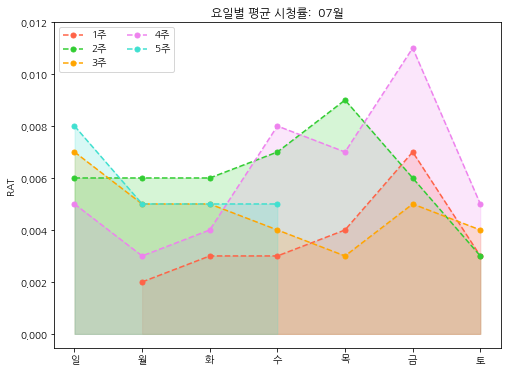

최대 시청률:  0.011000000000000001 
최소 시청률:  0.002
-----------------------------------
시청률 최댓값 정보:

     rating       date     day
206   0.011 2019-07-26  Friday
-----------------------------------
시청률 최솟값 정보:

     rating       date     day
181   0.002 2019-07-01  Monday


In [21]:
month = 6
day_graph2(month)
search_date(month)

### 8월

>* max: 0.015
* min: 0.002


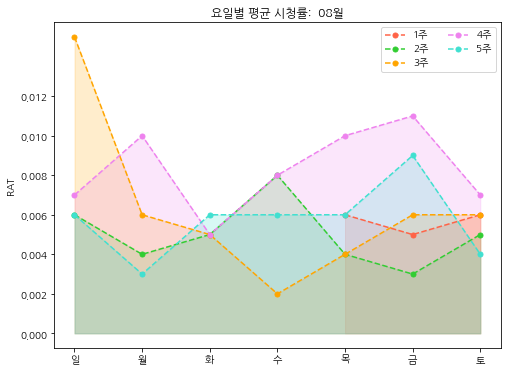

최대 시청률:  0.015 
최소 시청률:  0.002
-----------------------------------
시청률 최댓값 정보:

     rating       date     day
222   0.015 2019-08-11  Sunday
-----------------------------------
시청률 최솟값 정보:

     rating       date        day
225   0.002 2019-08-14  Wednesday


In [22]:
month = 7
day_graph2(month)
search_date(month)

### 9월

>* max: 0.013
* min: 0.002


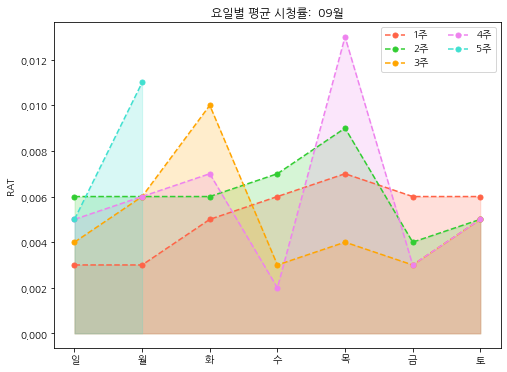

최대 시청률:  0.013000000000000001 
최소 시청률:  0.002
-----------------------------------
시청률 최댓값 정보:

     rating       date       day
268   0.013 2019-09-26  Thursday
-----------------------------------
시청률 최솟값 정보:

     rating       date        day
267   0.002 2019-09-25  Wednesday


In [23]:
month = 8
day_graph2(month)
search_date(month)

### 10월

>* max: 0.012
* min: 0.002



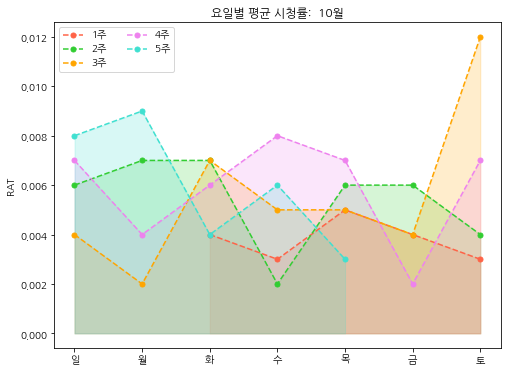

최대 시청률:  0.012 
최소 시청률:  0.002
-----------------------------------
시청률 최댓값 정보:

     rating       date       day
291   0.012 2019-10-19  Saturday
-----------------------------------
시청률 최솟값 정보:

     rating       date        day
281   0.002 2019-10-09  Wednesday
286   0.002 2019-10-14     Monday
297   0.002 2019-10-25     Friday


In [24]:
month = 9
day_graph2(month)
search_date(month)

### 11월

>* max: 0.013
* min: 0.002


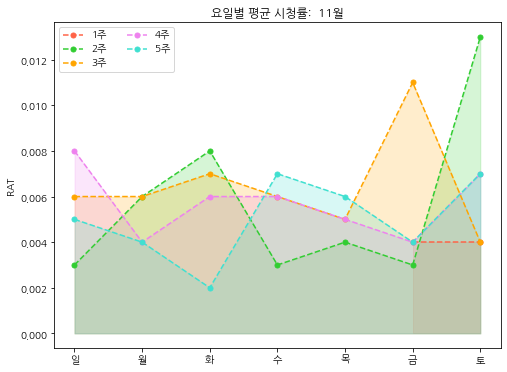

최대 시청률:  0.013000000000000001 
최소 시청률:  0.002
-----------------------------------
시청률 최댓값 정보:

     rating       date       day
312   0.013 2019-11-09  Saturday
-----------------------------------
시청률 최솟값 정보:

     rating       date      day
329   0.002 2019-11-26  Tuesday


In [25]:
month = 10
day_graph2(month)
search_date(month)

### 12월

>* max: 0.014
* min: 0.003


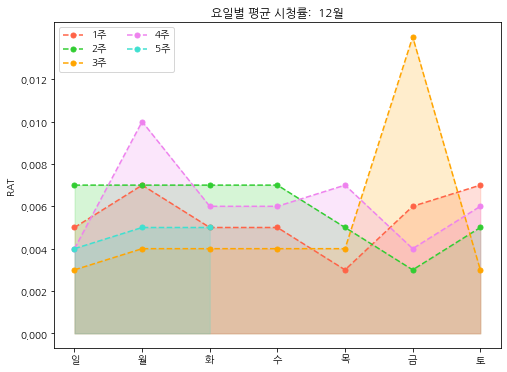

최대 시청률:  0.013999999999999999 
최소 시청률:  0.003
-----------------------------------
시청률 최댓값 정보:

     rating       date     day
353   0.014 2019-12-20  Friday
-----------------------------------
시청률 최솟값 정보:

     rating       date       day
338   0.003 2019-12-05  Thursday
346   0.003 2019-12-13    Friday
348   0.003 2019-12-15    Sunday
354   0.003 2019-12-21  Saturday


In [26]:
month = 11
day_graph2(month)
search_date(month)

### 1월 ~ 12월 출력

필요할 때 쓰기

In [27]:
#for i in range(12):
#    day_graph2(i)